# System State in the Temperature-Entropy Diagram
To always have a well-defined temperature for the system we need *diagonal* states throughout the evolution.
This is guarantee by the dynamical map if the system starts from a diagonal state.

In [1]:
import glob
from IPython.display import display, Image
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import qutip as qt
from qutip.visualization import plot_fock_distribution, plot_wigner

import tqdm

import uuid
import json
import os

from thermophaseonium.utilities.make_gif import create_gif
from thermophaseonium.utilities.states import Cavity, Ancilla

SEED = 42
rng = np.random.default_rng(SEED)

OMEGA = 0.5  # Interaction strength
N = 100  # Maximum number of dimensions

INTERACTION_TIME = 0.05
T_MAX = 1000
TIMESTEPS = np.linspace(0, T_MAX, int(T_MAX / INTERACTION_TIME))
print(f"Total of {len(TIMESTEPS)} timesteps from 0 to {T_MAX} with dt = {INTERACTION_TIME}")

Total of 20000 timesteps from 0 to 1000 with dt = 0.05


In [35]:
def dagger(matrix):
    return cp.conj(matrix.T)

def destroy(ndims):
    return cp.diag(cp.sqrt(cp.arange(1, ndims)), k=1)

def create(ndims):
    return cp.diag(cp.sqrt(cp.arange(1, ndims)), k=-1)

def anticommutator(op1, op2):
    return cp.dot(op1, op2) + cp.dot(op2, op1)

def commutator(op1, op2):
    return cp.dot(op1, op2) - cp.dot(op2, op1)

def cupy_temperature(rho):
    z = 1 / rho[0, 0]
    return cp.real(- 1 / cp.log(rho[1, 1] * z))

In [36]:
def create_isobaric_ancilla():
    """
    This is an ancilla that only exchange heat with the system without doing work
    :return: 
    """
    alpha = 0.4
    heat_amplitude = (1 - alpha**2) / 2
    chi01_phase = np.pi * 0
    chi02_phase = np.pi * 1
    chi12_phase = np.pi / 2
    chi01 = np.cos(chi01_phase) + 1j * np.sin(chi01_phase)
    chi02 = np.cos(chi02_phase) + 1j * np.sin(chi02_phase)
    chi12 = heat_amplitude * (np.cos(chi12_phase) + 1j * np.sin(chi12_phase))
    
    ancilla = Ancilla([
        [alpha**2, chi01, chi02],
        [chi01.conjugate(), (1 - alpha**2)/2, chi12],
        [chi02.conjugate(), chi12.conjugate(), (1 - alpha**2)/2]
    ])
    return ancilla


def create_adiabatic_ancilla():
    """
    This is an ancilla that only do work on the system without exchanging heat
    :return: 
    """
    alpha = 0.4
    work_amplitude = 1e-2
    chi01_phase = np.pi * 0.5
    chi02_phase = np.pi * 0.5
    # chi12_phase = np.pi * 0.5
    chi01 = work_amplitude * (np.cos(chi01_phase) + 1j * np.sin(chi01_phase))
    chi02 = work_amplitude * (np.cos(chi02_phase) + 1j * np.sin(chi02_phase))
    # chi12 = ( np.cos(chi12_phase) + 1j * np.sin(chi12_phase) )
    chi12 = 0 + 1j
    ancilla = Ancilla([
        [alpha**2, chi01, chi02],
        [chi01.conjugate(), (1 - alpha**2)/2, chi12],
        [chi02.conjugate(), chi12.conjugate(), (1 - alpha**2)/2]
    ])
    
    return ancilla


def ga(alpha_square):
    return 2 * alpha_square


def gb(beta_square, chi12):
    return beta_square + chi12 + chi12.conjugate()

ancilla = create_isobaric_ancilla()
print(f"Stable temperature: {ancilla.stable_temperature}")
ancilla

Stable temperature: 1.0361825667667512


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 1.60000000e-01+0.0000000e+00j  1.00000000e+00+0.0000000e+00j
  -1.00000000e+00+1.2246468e-16j]
 [ 1.00000000e+00+0.0000000e+00j  4.20000000e-01+0.0000000e+00j
   2.57175828e-17+4.2000000e-01j]
 [-1.00000000e+00-1.2246468e-16j  2.57175828e-17-4.2000000e-01j
   4.20000000e-01+0.0000000e+00j]]

In [37]:
n_photons = 3
system = Cavity(qt.thermal_dm(N, n_photons), omega=1)

system.temperature

3.476059496782207

## Evolution

In [38]:
def H_work(chi01, chi02, a, omega=OMEGA):
    upshift = (chi01 + chi02) * dagger(a)
    return omega * (upshift + dagger(upshift))

In [39]:
def D(op1, rho, op2=None):
    if op2 is None:
        op2 = op1
    return op1 * rho * dagger(op2) - anticommutator(dagger(op2) * op1, rho) / 2

In [46]:
def onestep_evolution(rho, eta, a, dt=INTERACTION_TIME, o=OMEGA):
    alpha, beta, chi01, chi02, chi12 = eta
    work = 1j * o * dt * commutator(H_work(chi01, chi02, a), rho)
    heat1 = ga(alpha) * ( o * dt ) ** 2 * D(dagger(a), rho)
    heat2 = gb(beta, chi12) * ( o * dt ) ** 2 * D(a, rho)
    rho_new = rho + work + heat1 + heat2
    return rho_new

In [47]:
def hilbert_is_good(rho, threshold=1e-6):
    """
    Check if the last element of the density matrix is almost null
    """
    return 0 <= abs(rho[-1, -1]) < threshold

In [48]:
def new_ancilla(ancilla, method='static', **kwargs):
    if method == 'static':
        return ancilla
    elif method == 'rotating':
        phis = np.linspace(0, 2 * np.pi, kwargs.get('timesteps', 10))
        ancilla.chi01 = phis[kwargs.get('step', -1)]
        ancilla.chi02 = phis[kwargs.get('step', -1)]
        return ancilla
    else:
        raise ValueError(f"Method {method} not recognized")


In [52]:
def stroke(kind, system, timesteps):
    if kind == 'adiabatic':
        ancilla = create_adiabatic_ancilla()
    elif kind == 'isobaric':
        ancilla = create_isobaric_ancilla()
    else:
        raise ValueError(f"Kind {kind} not recognized")
    
    a = destroy(N)
    eta = [ancilla.full()[0, 0], ancilla.full()[0, 1], ancilla.full()[0, 2], 2*ancilla.full()[1, 1], 2*ancilla.full()[1, 2]]
    if isinstance(system, Cavity):
        system = system.to_cupy()
    
    temperature_evolution = np.zeros(len(timesteps))
    entropy_evolution = np.zeros(len(timesteps))
    time_evolution = np.zeros(len(timesteps))
    
    print(f"Starting {kind} stroke from temperature {cupy_temperature(system)} to {ancilla.stable_temperature}")
    
    for k, t in enumerate(tqdm.tqdm(timesteps, desc=f"{kind.capitalize()} stroke")):
        temperature_evolution[k] = cupy_temperature(system)
        entropy_evolution[k] = Cavity(cp.asnumpy(system)).entropy
        
        time_evolution[k] = t
        try:
            rho_new =  onestep_evolution(system, eta, a)
        except ValueError as e:
            print(f"Error in computing the evolution at step {k} with t = {t}: {e}")
            # Return the last good state and the evolution up to this point
            return Cavity(cp.asnumpy(system)), temperature_evolution[:k], entropy_evolution[:k], time_evolution[:k]

        if not hilbert_is_good(system):
            print(f"Approximation no more valid at step {k} with t = {t}")
            return Cavity(cp.asnumpy(system)), temperature_evolution, entropy_evolution, time_evolution
        else:
            # Update the state
            system = rho_new
    
    return system, temperature_evolution, entropy_evolution, time_evolution

# Otto Cycle

In [53]:
rho = system

temperatures = []
entropies = []
times = []

## Isobaric stroke
In this stroke the system is coupled to classical phaseoniums and it is allowed to thermalize while its Hamiltonian is held constant

In [54]:
# Isobaric stroke
rho, temperature_evolution, entropy_evolution, time_evolution = stroke('isobaric', rho, TIMESTEPS)
temperatures.append(temperature_evolution)
entropies.append(entropy_evolution)
times.append(time_evolution)

Starting isobaric stroke from temperature 3.476059496782207 to 1.0361825667667512


Isobaric stroke:   9%|▉         | 1857/20000 [00:09<01:36, 188.98it/s]

Approximation no more valid at step 1857 with t = 92.85464273213661


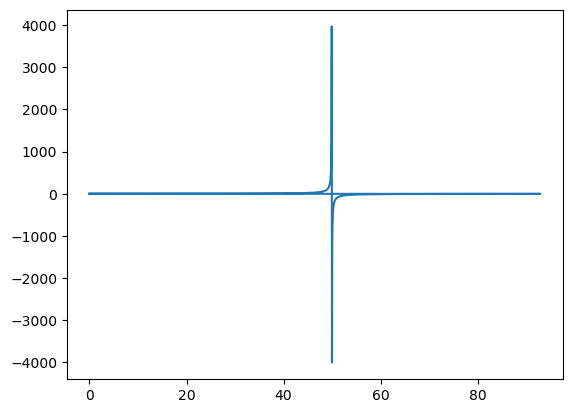

In [55]:
plt.plot(time_evolution, temperature_evolution, label='Isobaric Stroke Temperature Evolution')

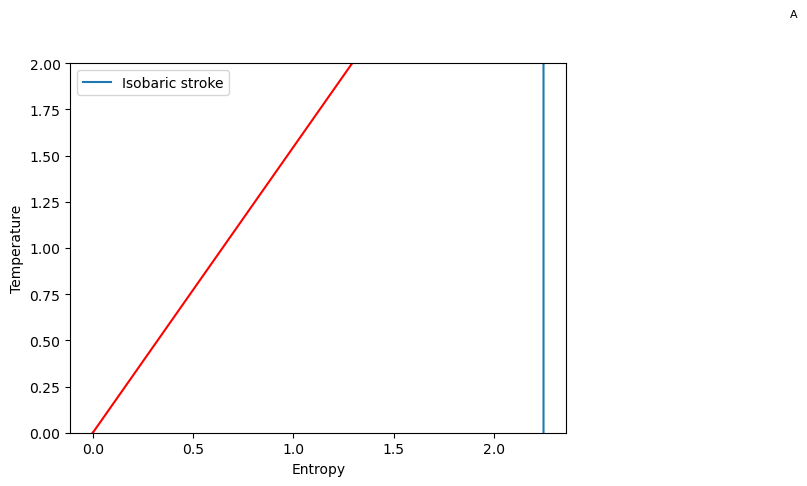

In [56]:
plt.plot(entropies[0], temperatures[0], label='Isobaric stroke')
plt.plot([entropy_evolution[0], entropy_evolution[-1]], [temperature_evolution[0], temperature_evolution[-1]], 'r')
plt.text(temperature_evolution[0], entropy_evolution[0], 'A', fontsize=8)
plt.xlabel('Entropy')
plt.ylabel('Temperature')
plt.legend()
plt.ylim(0, 2)
plt.show()

## Adiabatic stroke

In [71]:
# Adiabatic stroke
rho, temperature_evolution, entropy_evolution, time_evolution = stroke('adiabatic', rho, TIMESTEPS)
temperatures.append(temperature_evolution)
entropies.append(entropy_evolution)
times.append(time_evolution)

Starting adiabatic stroke from temperature 1.0361825966020337 to 1.0361825667667512


Adiabatic stroke: 100%|██████████| 100000/100000 [09:40<00:00, 172.15it/s]


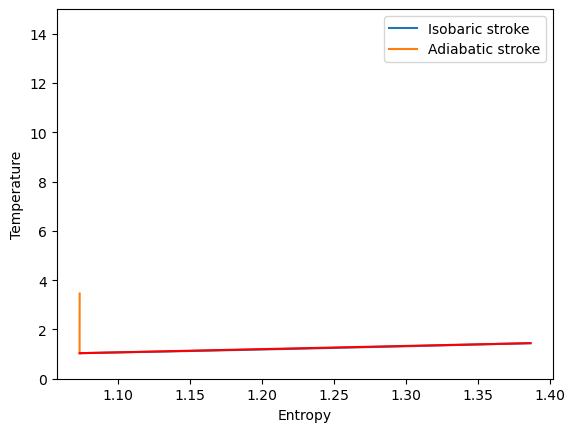

In [72]:
plt.plot(entropies[0], temperatures[0], label='Isobaric stroke')
plt.plot(entropies[1], temperatures[1], label='Adiabatic stroke')
plt.plot([entropies[0][0], entropies[0][-1]], [temperatures[0][0], temperatures[0][-1]], 'r')
plt.xlabel('Entropy')
plt.ylabel('Temperature')
plt.legend()
plt.ylim(0, 15)
plt.savefig("../visualization/ts_plane/adiabatic_stroke.png")
plt.show()

In [15]:
def ancilla_text(ancilla_obj):
    alpha = np.round(ancilla_obj.alpha**2, 3)
    chi01 = np.round(ancilla_obj.chi01, 3)
    chi02 = np.round(ancilla_obj.chi02, 3)
    chi12 = np.round(ancilla_obj.chi12, 3)
    beta = np.round(ancilla_obj.beta**2, 3)
    return (
        r"\begin{eqnarray*}"
        r"\textbf{Ancilla} \\"
       f"{alpha} & {chi01} & {chi02}" r"\\"
       f"{chi01.conjugate()} & {beta} & {chi12}" r"\\"
       f"{chi02.conjugate()} & {chi12.conjugate()} & {beta}"
       r"\end{eqnarray*}")

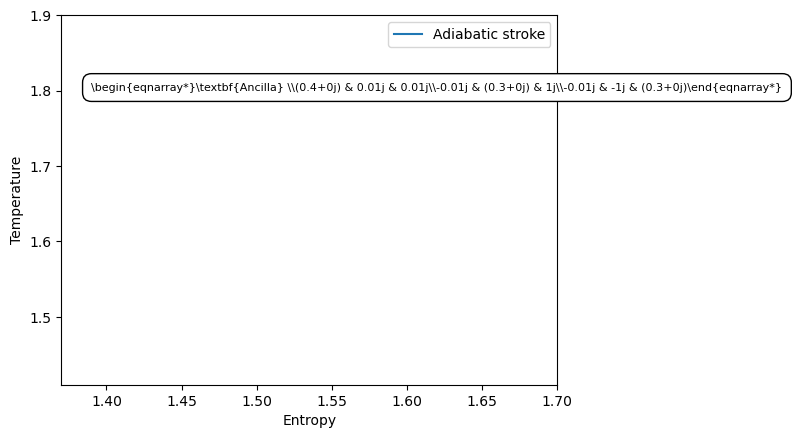

In [16]:
plt.plot(entropy_evolution, temperature_evolution, label='Adiabatic stroke')
plt.plot([entropy_evolution[0], entropy_evolution[-1]], [temperature_evolution[0], temperature_evolution[-1]], 'r')
plt.xlabel('Entropy')
plt.ylabel('Temperature')
plt.xlim(1.37, 1.7)
plt.ylim(1.41, 1.9)
plt.text(1.39, 1.8, ancilla_text(ancilla), fontsize=8, bbox=dict(boxstyle="round", fc="white", ec="black", pad=0.8))
plt.legend()
plt.savefig("../visualization/ts_plane/adiabatic_stroke.png")
plt.show()